In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
print('test')

test


In [5]:
pose_name_translation = {
    'adho mukha svanasana': 'downward_facing_dog',
    'ardha chandrasana': 'half_moon',
    'tadasana': 'mountain',
    'vriksasana': 'tree',
    'savasana': 'corpse',
    'anjaneyasana': 'low_lunge',
    'balasana': 'child',
    'bhujangasana': 'cobra',
    'dandasana': 'staff',
    'garudasana': 'eagle',
    'gomukhasana': 'cow_face',
    'halasana': 'plow',
    'hanumanasana': 'monkey',
    'kapotasana': 'pigeon',
    'malasana': 'garland',
    'matsyasana': 'fish',
    'natarajasana': 'dancer',
    'padmasana': 'lotus',
    'parivrtta trikonasana': 'revolved_triangle',
    'paschimottanasana': 'seated_forward_bend',
    'salabhasana': 'locust',
    'salamba sarvangasana': 'supported_shoulderstand',
    'sukhasana': 'easy',
    'supta virasana': 'reclining_hero',
    'ustrasana': 'camel',
    'utkatasana': 'chair',
    'uttanasana': 'standing_forward_bend',
    'virabhadrasana i': 'warrior_i',
    'virabhadrasana ii': 'warrior_ii',
    'virabhadrasana iii': 'warrior_iii',
    'virasana': 'hero',
    'vrischikasana': 'scorpion'
}


In [6]:
# Set the directories for dataset, train, and test
original_dataset_dir = '/kaggle/input/yoga-pose-image-classification-dataset/dataset'
working_dataset_dir = '/kaggle/working/dataset'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

In [7]:
# Copy the dataset to the working directory
shutil.copytree(original_dataset_dir, working_dataset_dir)

'/kaggle/working/dataset'

In [8]:
# Rename the pose folders
for pose_name, english_name in pose_name_translation.items():
    os.rename(os.path.join(working_dataset_dir, pose_name), os.path.join(working_dataset_dir, english_name))

In [9]:
# Split the dataset into training and testing
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

for english_name in pose_name_translation.values():
    pose_path = os.path.join(working_dataset_dir, english_name)
    pose_images = os.listdir(pose_path)
    
    train_images, test_images = train_test_split(pose_images, test_size=0.2, random_state=42)

    train_pose_path = os.path.join(train_dir, english_name)
    test_pose_path = os.path.join(test_dir, english_name)

    if not os.path.exists(train_pose_path):
        os.makedirs(train_pose_path)

    if not os.path.exists(test_pose_path):
        os.makedirs(test_pose_path)

    for image in train_images:
        shutil.move(os.path.join(pose_path, image), os.path.join(train_pose_path, image))

    for image in test_images:
        shutil.move(os.path.join(pose_path, image), os.path.join(test_pose_path, image))

In [10]:
# Model parameters
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32
epochs = 50
num_classes = len(pose_name_translation)

In [11]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1573 images belonging to 32 classes.
Found 411 images belonging to 32 classes.


In [13]:
# Load MobileNetV2 with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Transfer learning model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

In [16]:
# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_PRE.h5', monitor='val_loss', save_best_only=True)

In [18]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
19/50 [==========>...................] - ETA: 13s - loss: 3.4222 - accuracy: 0.1480

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/50 [==============================] - 36s 544ms/step - loss: 2.6174 - accuracy: 0.3134 - val_loss: 1.4689 - val_accuracy: 0.5839
Epoch 2/50
50/50 [==============================] - 27s 533ms/step - loss: 1.1050 - accuracy: 0.6796 - val_loss: 1.2090 - val_accuracy: 0.6667
Epoch 3/50
50/50 [==============================] - 27s 534ms/step - loss: 0.7313 - accuracy: 0.7959 - val_loss: 0.9539 - val_accuracy: 0.7275
Epoch 4/50
50/50 [==============================] - 26s 519ms/step - loss: 0.5370 - accuracy: 0.8392 - val_loss: 0.9699 - val_accuracy: 0.7275
Epoch 5/50
50/50 [==============================] - 26s 517ms/step - loss: 0.4087 - accuracy: 0.8868 - val_loss: 0.8844 - val_accuracy: 0.7445
Epoch 6/50
50/50 [==============================] - 26s 521ms/step - loss: 0.3203 - accuracy: 0.9072 - val_loss: 0.9170 - val_accuracy: 0.7372
Epoch 7/50
50/50 [==============================] - 26s 517ms/step - loss: 0.2716 - accuracy: 0.9256 - val_loss: 0.9500 - val_accuracy: 0.7518
Epoch 8/50

In [19]:
# Load the best model
model.load_weights('best_model_PRE.h5')

In [20]:
# Evaluate the model
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 3s 193ms/step - loss: 0.8296 - accuracy: 0.7689
Test loss: 0.8295907974243164
Test accuracy: 0.7688564658164978


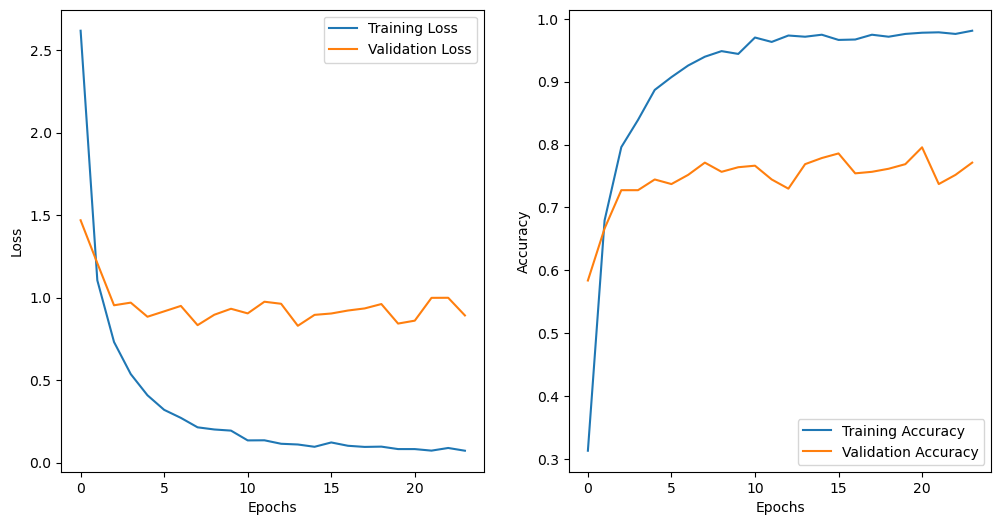

In [21]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/YogaPoseClassModelPre/best_model_PRE.h5')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                32800     
                                                                 
Total params: 3,602,528
Trainable params: 1,344,544
Non-